# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Mohamed"
ln1 = "EL FAKIR"
fn2 = "Amine"
ln2 = "ELKARI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_el fakir_mohamed_and_elkari_amine.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [4]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [5]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


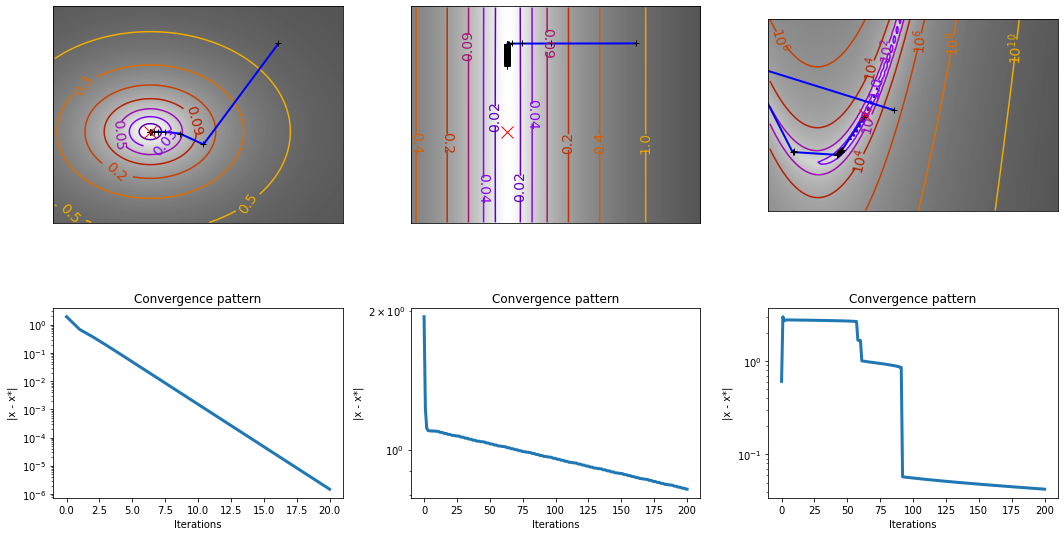

In [6]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [47]:
from scipy import linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001 # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO H = ..
        #H = np.linalg.solve(f_hessian(x) + lambda_threshold * np.eye(len(x)),np.eye(len(x)))
        #d = - H @ grad_x
        H = f_hessian(x)
        eigenvalues = np.linalg.eigvals(H)
        if (eigenvalues >= lambda_threshold).all() == False :
            H = H + (lambda_threshold - min(eigenvalues))* np.identity(H.shape[0])
        d = - np.linalg.solve(H, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


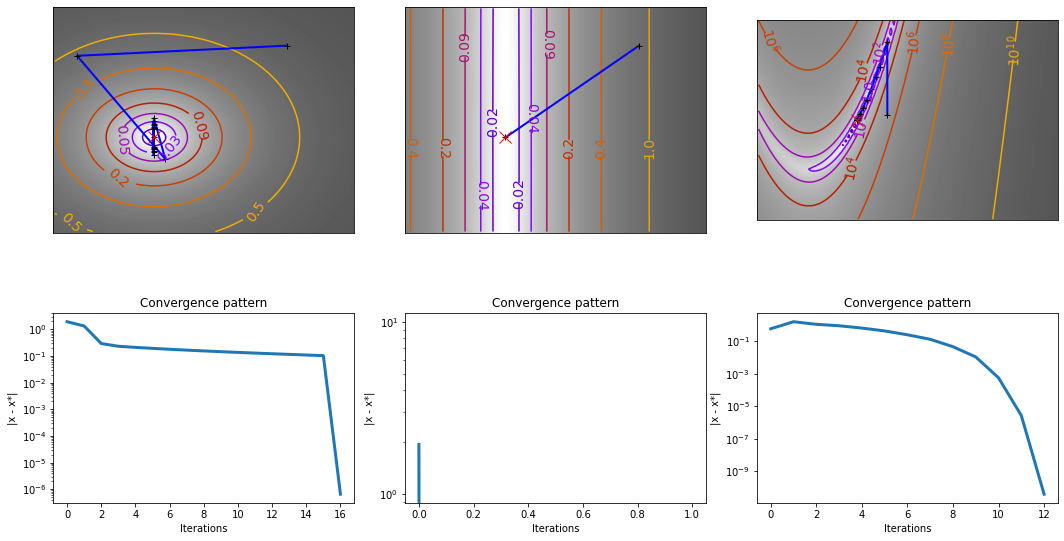

In [48]:
test_solver(newton)

<div class="alert alert-success">
<span class="label label-success" style="font-size:15px;">ANSWER</span>


* Function 1: For the non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$), the model was able to converge after 16 iterations.  We also see that the convergence slope becomes steepest when close to the optimum, and this is in concordance with what we've seen in class concerning the convergence being quadratic locally around $x_{*}$.
* Function 2: This function is strongly convex and quadratic. As we've seen in class the Newton algorithm converges after just 1 iteration for quadratic functions independently of the starting point $x_{0}$!</li>
* Function 3: The Rosenbrock function is known for the hard times it gives to minimum seeking algorithms as its shape makes it hard for these algorithms to find the minimum. It is a non-convex function, but the Newton algorithm was still able to find the minimum after 12 iterations. Also as we can see in the very first iteration, we actually see that the algorithm diverges from the minima, this is normal as we've seen that the Newton  direction can sometimes not be a descent direction.</li>
</ul>
</div>

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [49]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = ...
        term_1 = np.outer(s, s) / s.dot(y)
        term_2 = B.dot(np.outer(y, y)).dot(B) / y.dot(B).dot(y)
        B = B + term_1 - term_2
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


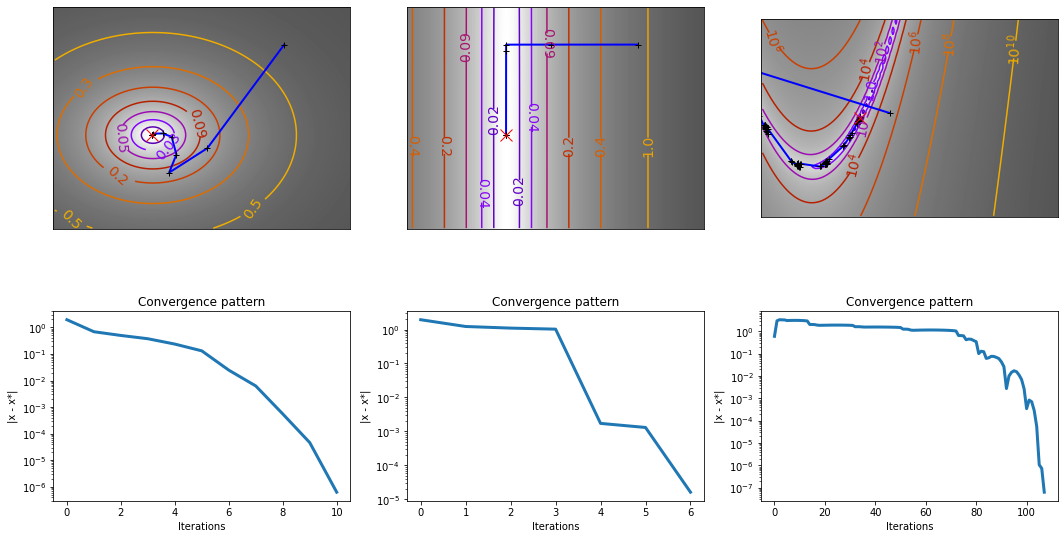

In [50]:
test_solver(dfp)

<div class="alert alert-success">
<span class="label label-success" style="font-size:15px;">ANSWER</span>
<ul>
    <li>Function 1: DFP converges in less iterations (10 against 16). It seems that the Hessian's rank 2 correction gives better results for the gaussian kernel and the DFP algorithm starts with a positive semi-definite inverse Hessian matrix and updates it in a way that maintains its positive semi-definiteness.</li>
    <li>Function 2: For quadratic functions, DFP behaves like a conjugate gradient descent algorithm and is supposed to have converge in at most n iterations (in our case n=2). This clearly isn't the case here. The previous statement holds under the condition that the step size is optimal, but here, the step size computed by line search is an approximation of the optimal step size.</li>
    <li>Function 3: The convergence of this function is much slower than when using newton's descent. Perhaps it is due to a small step size given the approximations (the DFP method uses an approximation of the inverse Hessian matrix which may not accurately capture the curvature of the Rosenbrock curve and therefore may not be as effective).</li>
</ul>
</div>

# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [51]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = 
        mu = 1/ np.dot(y,s)
        A = np.eye(len(x)) - mu * np.outer(y,s)
        B = A.T @ B @ A + mu * np.outer(s, s)     
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


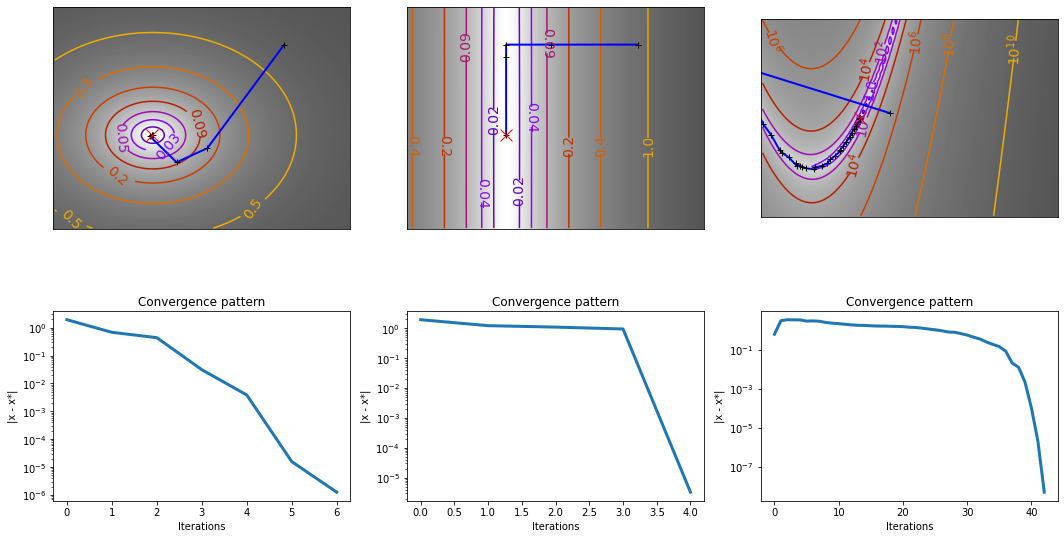

In [52]:
test_solver(bfgs)

<div class="alert alert-success">
<span class="label label-success" style="font-size:15px;">ANSWER</span>
<ul>
    <li>All 3 functions converge in much less iterations using BGFS compared to DFP even though both algorithms have the same computational cost, and that is because BGFS is less sensitive to the optimal step size (less sensitive to line-search inaccuracy) and works well with an approximation of the latter using line search.</li>

</ul>
</div>

# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [42]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu
        
    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    m = len(s_list)
    for i in reversed(range(m)):
        alpha = mu_list[i] * s_list[i].dot(q)
        q = q - alpha * y_list[i]
        alpha_list.append(alpha)
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(m):
        beta = mu_list[i] * y_list[i].dot(r)
        r = r + s_list[i] * (alpha_list[m-1-i] - beta) 
    return -r

In [43]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


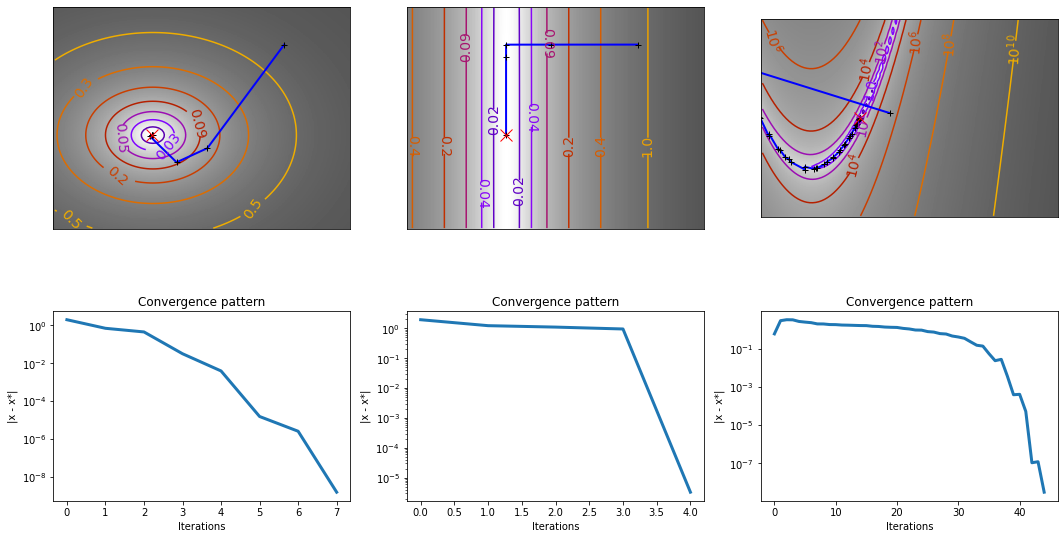

In [44]:
test_solver(lbfgs)

<div class="alert alert-success">
<span class="label label-success" style="font-size:15px;">ANSWER</span>
<ul>
    <li>We don't see much different between BGFS and LGBFS. And that is because LGBFS is meant to limit memory usage (storying computations), and because in this case n is only equal to 2, there won't be much difference between the two algorithms.</li>
    <li>Although we do notice that for the Gaussian kernel, the algorithm converges after 7 iterations against 6 for BGFS, perhaps that is because LGBFS doesn't store the complete hessian and that slows its convergence given the small dimension.</li>

</ul>
</div>